In [165]:
import jax.numpy as np
import numpy as rnp
from qutip import *
from jax import grad
from jax.random import normal, PRNGKey


$R(\phi,\theta,\omega) = RZ(\omega)RY(\theta)RZ(\phi)= \begin{bmatrix}
e^{-i(\phi+\omega)/2}\cos(\theta/2) & -e^{i(\phi-\omega)/2}\sin(\theta/2) \\
e^{-i(\phi-\omega)/2}\sin(\theta/2) & e^{i(\phi+\omega)/2}\cos(\theta/2)
\end{bmatrix}$

# TODO:
- Compare fidelity and $\sigma_{z}$ in the cost function and comapre results 
- Investigate the issue of differentiating matrices 
- ` x = np.array([[1, 2, 3, 4, 5]])` $\rightarrow$ `Qobj(x)` gives an empty `Qobj` for JAX wrapped array?
- Exactly the same derivative values for wrt to the first and the third cost parameter


In [267]:
def rot(phi, theta, omega):
    cos = np.cos(theta/2)
    sin = np.sin(theta/2)

    return np.array(
    [
        [np.exp(-0.5j*(phi+omega))*cos, -(np.exp(0.5j*(phi-omega)))*sin],
        [np.exp(-0.5j*(phi-omega))*sin, np.exp(0.5j*(phi+omega))*cos],
        
    ]
    )

def cost(ket):
    
    evolved = np.dot(rot, ket)
    dot = np.dot(evolved.T,basis(2,0).full())
    fidel = np.absolute(dot)**2
    return fidel[0][0]



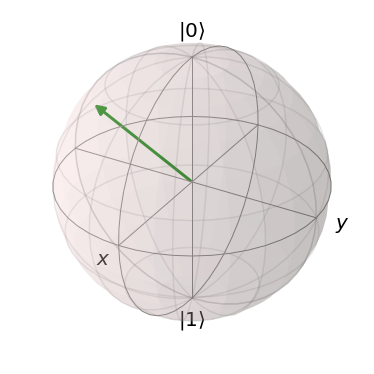

In [151]:
b = Bloch()
#b.add_states(basis(2,0))
#b.add_states(basis(2,1))
b.add_states(rand_ket(2))
b.show()

In [245]:
## Gradient Descent 


#gradient descent implementation 
#initialize parameters for descent
epochs = 10
alpha = 0.01
tol = 1e-7
diff = 1
max_iters = 50
iters = 0
fidel_hist = []
params_hist = []
key = PRNGKey(0) #Generate a PRNG key
weights = normal(key=key, shape=(3,))
der_cost = grad(cost, argnums = [0,1,2])

ket = rand_ket(2)
params = [0.1, 0.2, 0.3]
evolv = np.dot(rot(*params),ket.full())
cost(evolv)

for epoch in range (epochs):
    iters = 0
    #weights = weights + np.random.normal(size=(2*N,1))
    while np.all(diff > tol) and iters < max_iters:
        prev_weights = weights
        weights = weights - alpha*(np.asarray(der_cost(*prev_weights.T)))
        iters += 1
        diff = np.absolute(weights-prev_weights)
    fidel = cost(*weights)
    progress = [epoch+1, fidel]
    fidel_hist.append(fidel)
    #params_hist.append(weights)
    if ((epoch)%10==9):
        print("Epoch: {:2f} | Fidelity: {:3f}".format(*np.asarray(progress)))
    
opt_params = weights

Traced<ConcreteArray(0.94289035)>with<JVPTrace(level=1/0)>
  with primal = DeviceArray(0.94289035, dtype=float32)
       tangent = Traced<ShapedArray(float32[]):JaxprTrace(level=0/0)>
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
0.9423506
Epoch: 10.000000 | Fidelity: 0.942351


In [238]:
a = np.array([0.1, 0.2, 0.3])
weights = normal(key=key, shape=(3,))

arr = np.asarray(der_cost(*weights.T))
print(der_cost(*weights.T))
print(arr,arr.shape)


Traced<ConcreteArray(0.94289035)>with<JVPTrace(level=1/0)>
  with primal = DeviceArray(0.94289035, dtype=float32)
       tangent = Traced<ShapedArray(float32[]):JaxprTrace(level=0/0)>
Traced<ConcreteArray(0.94289035)>with<JVPTrace(level=1/0)>
  with primal = DeviceArray(0.94289035, dtype=float32)
       tangent = Traced<ShapedArray(float32[]):JaxprTrace(level=0/0)>
(DeviceArray(0., dtype=float32), DeviceArray(0.23205219, dtype=float32), DeviceArray(0., dtype=float32))
[0.         0.23205219 0.        ] (3,)
